In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from pathlib import Path
import pandas as pd
from latex_formater import get_final_answer

save_path = Path('~/GitHub/gold-ai-olympiad/data/MATH/Predictions/').expanduser()

# load the results and combine them back into a single dataframe
results = pd.concat([
    pd.read_json(save_path / f)
    for f in save_path.iterdir()
    if f.suffix == '.json'
])

In [2]:
print(f'Loaded {len(results)} results')

results.iloc[0]

dataset                               Counting_and_Probability_train
i                                                                  0
problem              What is the value of $9^3 + 3(9^2) + 3(9) + 1$?
level                                                        Level 1
type                                          Counting & Probability
solution           The given expression is the expansion of $(9+1...
boxed                                                           1000
model                                                    Llama-2-13b
method                                                autoregressive
prediction          Sure! Here's the calculation:\n\n$9^3 = 9 \ti...
generation_args    {'debug': False, 'seed': None, 'model': 'meta-...
Name: 0, dtype: object

In [3]:
class Metric():
    def __init__(self):
        super().__init__()

    def process(self, results):
        pass

    def __call__(self, results):
        return self.process(results)

In [4]:
class BoxedMatch(Metric):
    def process(self, results):
        results['boxed_pred'] = results['prediction'].apply(get_final_answer)
        results['boxed_true'] = results['boxed']
        results['boxed_match'] = results['boxed_true'] == results['boxed_pred']

        # very slow, probably don't use
        # results['match'] = results.apply(lambda x: is_equiv(x['boxed_true'], x['boxed_pred']), axis=1)

        # set first columns to be ['dataset', 'i', 'model', 'method', 'boxed_true', 'boxed_pred', 'match', ...]
        # cols = ['dataset', 'i', 'model', 'method', 'boxed_true', 'boxed_pred', 'boxed_match']
        # cols.extend([col for col in results.columns if col not in cols])
        return results  #[cols]

In [5]:
from nltk.tokenize import sent_tokenize

from roscoe.score import (
    SEQ_EMB_MODEL_TYPES,
    Chain,
    Evaluator,
    REASONING_SCORES,
    UNSUPERVISED_SCORES,
    SENT_TRANS,
    SIMSCE
)
from roscoe.utils import (
    print_and_reset_max_gpu_memory,
    save_scores,
    split_gsm8k_gpt3_generations_to_steps,
)


class ReasoningSteps(Chain):
    def __init__(self, line: str, type="regular") -> None:
        self.chain = self.parse_chain(line, type=type)

    def parse_chain(self, chain: str, type: str) -> list[str]:
        """
        Change formatting.

        Returns list of steps in reasoning chain.
        """
        if type == "gsm8k_ref":
            return chain.split("IGNORE THIS. Ground truth here for reference. ")[
                1
            ].split('\n')
        elif type == "gsm8k_hypo":
            return split_gsm8k_gpt3_generations_to_steps(reasoning=chain)
        elif type == "regular":
            return sent_tokenize(chain)
        else:
            raise NotImplementedError(f"{type} chain type is not supported")

In [6]:
# # get memory usage of evaluator.ppl_model
# param_size = 0
# for param in evaluator.grmr_model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in evaluator.grmr_model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()
# 
# size_all_mb = (param_size + buffer_size) / 1024 ** 3
# print('model size: {:.3f}GB'.format(size_all_mb))

In [17]:
from roscoe.score import Evaluator


class ROSCOE(Metric):
    def __init__(self, score_types=REASONING_SCORES, model_type=SIMSCE,
                 transformer_model="facebook/roscoe-512-roberta-base", ppl_model="gpt2-large", discourse_batch=64,
                 coherence_batch=16):
        super().__init__()
        self.evaluator = Evaluator(
            score_types=score_types,
            model_type=model_type,
            transformer_model=transformer_model,
            ppl_model=ppl_model,
            discourse_batch=discourse_batch,
            coherence_batch=coherence_batch,
            hypos=[],
            context=[],
        )

    def process(self, results):
        hypos = [
            ReasoningSteps(str(pred))
            for pred in results['prediction']
        ]
        refs = [
            ReasoningSteps(str(solution))
            for solution in results['solution']
        ]
        context = [
            ReasoningSteps(str(problem))
            for problem in results['problem']
        ]

        self.evaluator.set_hypos(hypos)
        self.evaluator.set_references(refs)
        self.evaluator.set_context(context)
        scores = self.evaluator.evaluate()
        results['ROSCOE'] = scores
        return results

In [8]:
# import torch
# 
# torch.set_float32_matmul_precision('medium')

from comet import download_model, load_from_checkpoint


class COMET(Metric):
    def __init__(self, model_name="Unbabel/XCOMET-XL", batch_size=16, gpus=1):
        super().__init__()
        self.model_name = model_name
        self.model_path = download_model(model_name)
        self.model = load_from_checkpoint(self.model_path)

        self.batch_size = batch_size
        self.gpus = gpus

    def process(self, results):
        data = [
            {
                "src": row['problem'],
                "mt": row['prediction'],
                "ref": row['solution']
            } for _, row in results.iterrows()
        ]
        model_output = self.model.predict(data, batch_size=self.batch_size, gpus=self.gpus)
        results[self.model_name] = model_output
        return results

In [9]:
boxed_match = BoxedMatch()
results = boxed_match(results)

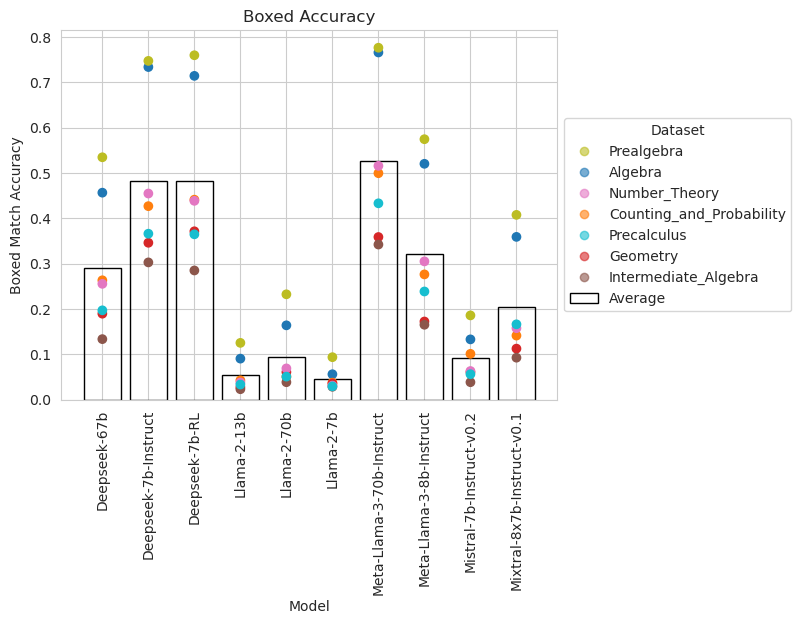

In [10]:
# plot the results
import matplotlib.pyplot as plt

boxed_accuracy = results.groupby(['model', 'dataset'])['boxed_match'].mean()
model_accuracy = boxed_accuracy.groupby('model').mean()
dataset_accuracy = boxed_accuracy.groupby('dataset').mean()

plt.bar(model_accuracy.index, model_accuracy, edgecolor='black', linewidth=1, color='none')

# plot each dataset as a separate point with model on the x axis and boxed_match on the y axis
boxed_accuracy = results.groupby(['model', 'dataset'])['boxed_match'].mean()

colors = pd.Categorical(boxed_accuracy.index.get_level_values('dataset'))
scatter = plt.scatter(boxed_accuracy.index.get_level_values('model'), boxed_accuracy, c=colors.codes, cmap='tab10')
plt.xlabel('Model')
plt.ylabel('Boxed Match Accuracy')
plt.title('Boxed Accuracy')
handles, labels = scatter.legend_elements(prop='colors', alpha=0.6, fmt='{x:.0f}')
labels = [colors.categories[int(label)].replace('_train', '') for label in labels]

# sort the legend by the average accuracy
sorted_idxs = dataset_accuracy.sort_values(ascending=False).index
handles = [handles[colors.categories.get_loc(dataset)] for dataset in sorted_idxs]
labels = [labels[colors.categories.get_loc(dataset)] for dataset in sorted_idxs]

# add bars to the legend
handles.append(plt.Rectangle((0, 0), 1, 1, fc='none', edgecolor='black'))
labels.append('Average')

plt.legend(
    handles, labels,
    title='Dataset',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.xticks(rotation=90)

plt.show()

In [ ]:
roscoe = ROSCOE()
results = roscoe(results)

Some weights of RobertaModel were not initialized from the model checkpoint at facebook/roscoe-512-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 30%|████████████████████████                                                        | 352/1172 [00:29<01:17, 10.54it/s]